In [2]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, pulse
#from qiskit.tools.monitor import job_monitor
#from qiskit.tools.jupyter import *
from qiskit.compiler import assemble
import pandas as pd

In [3]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_bogota')
backend_defaults = backend.defaults()
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
calibrations = backend_defaults.instruction_schedule_map
x_schedules = [calibrations.get('x',i) for i in range(backend_config.n_qubits)]

In [5]:
import matplotlib.pyplot as plt
x_schedules[0].draw()
plt.savefig("x_schedule.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.savefig("x_schedule.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.savefig("x_schedule.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
couples = [list(x) for x in set(tuple(x) for x in backend_config.coupling_map)]
print(couples)

[[0, 1], [1, 2], [2, 3], [3, 4]]


In [39]:
qubit = 0

meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
inst_sched_map = backend_defaults.instruction_schedule_map
results = []
for couple in couples:
    measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])
    gnd_schedule = pulse.Schedule(name="00 state")
    gnd_schedule += measure

    schedules = [gnd_schedule]

    drive_chan_0 = pulse.DriveChannel(couple[0])
    meas_chan_0 = pulse.MeasureChannel(couple[0])
    acq_chan_0 = pulse.AcquireChannel(couple[0])

    drive_chan_1 = pulse.DriveChannel(couple[1])
    meas_chan_1 = pulse.MeasureChannel(couple[1])
    acq_chan_1 = pulse.AcquireChannel(couple[1])

    center_frequency_Hz_0 = backend_defaults.qubit_freq_est[couple[0]]
    center_frequency_Hz_1 = backend_defaults.qubit_freq_est[couple[1]]

    schedules.append(pulse.Schedule(name='01'.format()))
    schedules[-1] += x_schedules[couple[0]]
    schedules[-1] += measure << schedules[-1].duration

    schedules.append(pulse.Schedule(name='10'.format()))
    schedules[-1] += x_schedules[couple[1]]
    schedules[-1] += measure << schedules[-1].duration

    schedules.append(pulse.Schedule(name='11'.format()))
    schedules[-1] += x_schedules[couple[0]]
    schedules[-1] += x_schedules[couple[1]]
    schedules[-1] += measure << schedules[-1].duration

    num_shots_per_schedule = 1024

    program = assemble(schedules,
                                       backend=backend, 
                                       meas_level=1,
                                       meas_return='single',
                                       shots=num_shots_per_schedule,
                                       schedule_los=[{drive_chan_0: center_frequency_Hz_0, drive_chan_1: center_frequency_Hz_1}] * len(schedules))
    job = backend.run(program)
    job_monitor(job)
    result = job.result()
    results.append(result)
    
%store results

C:\Users\usuario\AppData\Roaming\Python\Python38\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Stored 'results' (list)


In [67]:
from matplotlib import pyplot as plt
import numpy as np
scale_factor = 0.7

for i in range(len(couples)):
    result = results[i]
    print('Couple',i)
    df = pd.DataFrame(data={'x_1': result.get_memory(0)[:, couples[i][0]].real, 'x_2': result.get_memory(0)[:, couples[i][0]].imag, 'y': 0})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_00_0.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(0)[:, couples[i][1]].real, 'x_2': result.get_memory(0)[:, couples[i][1]].imag, 'y': 0})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_00_1.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(1)[:, couples[i][0]].real, 'x_2': result.get_memory(1)[:, couples[i][0]].imag, 'y': 1})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_10_0.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(1)[:, couples[i][1]].real, 'x_2': result.get_memory(1)[:, couples[i][1]].imag, 'y': 0})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_10_1.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(2)[:, couples[i][0]].real, 'x_2': result.get_memory(2)[:, couples[i][0]].imag, 'y': 0})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_01_0.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(2)[:, couples[i][1]].real, 'x_2': result.get_memory(2)[:, couples[i][1]].imag, 'y': 1})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_01_1.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(3)[:, couples[i][0]].real, 'x_2': result.get_memory(3)[:, couples[i][0]].imag, 'y': 1})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_11_0.csv'.format(couples[i][0],couples[i][1]),index=False)
    df = pd.DataFrame(data={'x_1': result.get_memory(3)[:, couples[i][1]].real, 'x_2': result.get_memory(3)[:, couples[i][1]].imag, 'y': 1})[['x_1','x_2','y']]
    df.to_csv('data/dataset_bogota_{0}_{1}_11_1.csv'.format(couples[i][0],couples[i][1]),index=False)
    

Couple 0
Couple 1
Couple 2
Couple 3


In [66]:
df

,x_1,x_2,y
0,28723230.0,-88202952.0,1
1,56917912.0,-82410096.0,1
2,38492960.0,-82972504.0,1
3,47223868.0,-95581616.0,1
4,14574164.0,-89250624.0,1
...,...,...,...
1019,18728568.0,-80205064.0,1
1020,29340764.0,-107102288.0,1
1021,46207536.0,-104772168.0,1
1022,29932656.0,-72390448.0,1


## Configurations retrieval

In [3]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_bogota')
retrieved_job = backend.retrieve_job('605bddbdef04bbe8375fa555')

C:\Users\usuario\AppData\Roaming\Python\Python38\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [12]:
retrieved_job

In [35]:
retrieved_job.qobj().experiments[1].instructions[0].to_dict()

{'name': 'parametric_pulse',
 't0': 0,
 'ch': 'd0',
 'pulse_shape': 'drag',
 'parameters': {'duration': 160,
  'amp': (0.19041175559266285+0j),
  'sigma': 40,
  'beta': -1.1813680761122822}}

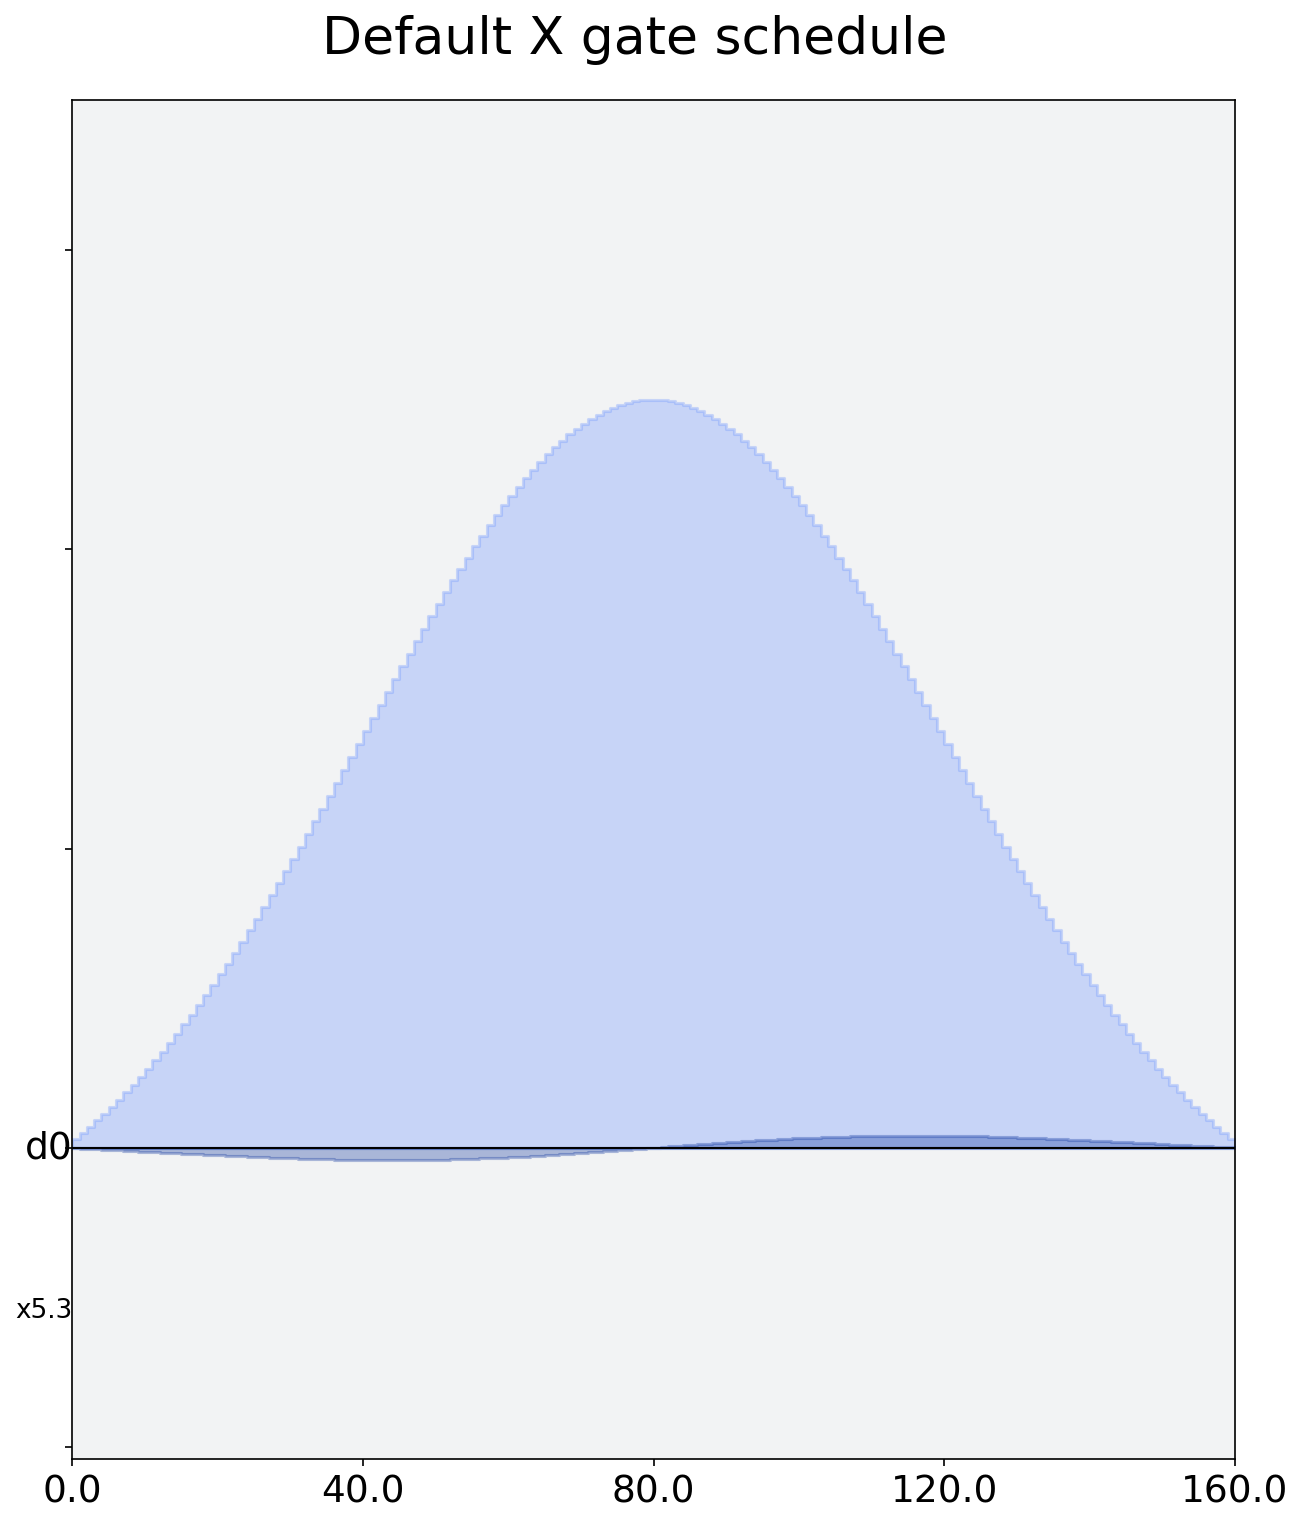

In [49]:
params = retrieved_job.qobj().experiments[1].instructions[0].to_dict()['parameters']
pulse_1_state = pulse.Drag(params['duration'],params['amp'],params['sigma'],params['beta'])
sched = pulse.Schedule(name='Default X gate schedule')
sched += pulse.Play(pulse_1_state, pulse.DriveChannel(0))
sched.draw()

In [50]:
schedule_plot = sched.draw()
schedule_plot.savefig('x_pulse_0.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
schedule_plot.savefig('x_pulse_0.svg', transparent = True, bbox_inches = 'tight', pad_inches = 0)
schedule_plot.savefig('x_pulse_0.png', dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [67]:
for i in range(5):
    print('Qubit {0} had a readout_error of {1}'.format(i,retrieved_job.properties().readout_error(i)))

Qubit 0 had a readout_error of 0.04069999999999996
Qubit 1 had a readout_error of 0.08400000000000007
Qubit 2 had a readout_error of 0.021499999999999964
Qubit 3 had a readout_error of 0.023800000000000043
Qubit 4 had a readout_error of 0.02510000000000001
